## Soma Analysis

Data: the somas being analysed here were manually selected by Kathleen and called usign Soma caller by Aashir. 

Objective: compare binary called barcode distribution, collisions, length to full neurite volume of predicted binary calls. 

## Defining functions for soma analysis

In [2]:
import zarr #open files
import sklearn.metrics as sn
from sklearn.decomposition import PCA 
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import distance

import math
import os
import textwrap
from adjustText import adjust_text
from itertools import combinations
import datetime

# colab specific -- mount drive
# drive.mount('/content/drive'

# seaborn and defaults

## seaborn settings
e11_color = '#005787'
e11_bright = "#26BFF2"
date_str = datetime.datetime.now().strftime('%y%m%d')

sns.set_theme(context='notebook', style='darkgrid')

## helper function to break titles normally
def break_title(title, figsize, min_line_width=20, avg_char_width=0.2):
    
    """
    Break a title into lines with a specified maximum width to fit in a plot.

    Parameters:
        title (str): The title to be broken into lines.
        figsize (tuple): Tuple representing the width and height of the plot.
        max_line_width (int): Maximum width of each line in characters.
        avg_char_width (float): Average width of a character in inches.

    Returns:
        str: Title text with line breaks.
    """
    plot_width, plot_height = figsize

    # Calculate the maximum number of characters per line
    max_chars_per_line = max(min_line_width, int(plot_width / avg_char_width))

    # Break the title into lines with maximum width
    broken_title = textwrap.fill(title, width=max_chars_per_line)

    return broken_title


def generate_export_title(user_string, sample_id, date_str = date_str, output_type = 'png'):
    # Get the current date and format it as YYMMDD
    if date_str is None:
        date_str = datetime.datetime.now().strftime('%y%m%d')
    
    # Create the title string by combining user string, sample ID, and formatted date
    title = f"{date_str}_{sample_id}_{user_string}.{output_type}"
    return title


def annotate_bars(ax=None, fmt='.2f', **kwargs):
    ax = plt.gca() if ax is None else ax
    for p in ax.patches:
         ax.annotate('{{:{:s}}}'.format(fmt).format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                     xytext=(0, 5),textcoords='offset points',
                     ha='center', va='center', **kwargs)



def import_zarr(file):
    vals = zarr.open(file, mode="r")
    df = pd.DataFrame({'coords': vals['coords'][:].tolist(),
                   'score': vals['score'][:].tolist(),
                   'is_cell': vals['is_cell']})
    return df

## processing columns now that we made them

def process_zarr(df):
    max_score_length = max(len(score) for score in df['score'])
    score_columns = [f'ch_{i}' for i in range(max_score_length)]
    
    # Split the 'score' column into individual columns
    df[score_columns] = pd.DataFrame(df['score'].tolist(), index=df.index)

    #get coordinates for each cell
    df[['z', 'y', 'x']] = pd.DataFrame(df['coords'].tolist(), index=df.index)

    return df, score_columns
    

## statistics on the data frame
def calc_df_statistics(df, score_columns):
    """
    Calculate and append summary statistics to the dataframe for plotting purposes,
    returning a dictionary of helper variables describing the dataframe.

    This function computes summary statistics based on specified score columns of the input dataframe.
    It adds a new column to the dataframe representing the sum of scores across the specified columns.
    It calculates the count, mean, and maximum of this new column, along with the rounded mean, rounded
    standard deviation, and the number of score columns (considered as channels). These statistics are
    compiled into a dictionary intended to assist in plotting and understanding the distribution of the
    computed scores.

    Parameters:
    - df (pandas.DataFrame): The input dataframe with pre-split channels.
    - score_columns (list of str): The column names in `df` to be summed for scoring.

    Returns:
    - statistics (dict): A dictionary containing the following key-value pairs:
      - 'df': The modified dataframe including the new summed scores column.
      - 'x_col': The name of the newly added column containing summed scores.
      - 'ct': The total count of rows/cells/segments in `df`.
      - 'mu': The mean of the values in the new summed scores column.
      - 'maximum': The maximum value in the new summed scores column.
      - 'round_mu': The mean of the values in the new column, rounded to the nearest whole number.
      - 'round_std': The standard deviation of the values in the new column, rounded to one decimal place.
      - 'num_bits': The number of score columns, representing the number of channels.

    Note:
    - The `rounds` parameter is currently not utilized in the function's logic but is included for potential future use or context.
    """
    df['bc_length'] = df[score_columns].sum(axis=1)
    mu = df['bc_length'].mean()
    statistics = {
        'x_col': 'bc_length',
        'ct': len(df['bc_length']),  # This is how many cells or segments we have.
        'mu': mu,  # Mean of the number of epitopes e.g. bit fraction.
        'maximum': df['bc_length'].max(),  # For poisson calculations.
        'round_mu': np.round(mu,0),  # Rounded mean.
        'round_std': np.round(df['bc_length'].std(), 1),  # Rounded std.
        'num_bits': len(score_columns)  # Number of score columns (channels).
    }

    return statistics
def calc_poisson_freq(x, mean):
    """
    Calculate the Poisson frequency at a given x given a mean.

    Parameters:
    - x: Value for which to calculate the Poisson frequency.
    - mean: Mean of the Poisson distribution.

    Returns:
    - Probability of observing the given value x in a Poisson distribution with the specified mean.
    """
    if type(x) != int:
        print('Note: converting x value to int')
        x = int(x)
    prob = np.exp(-mean) * np.power(mean, x) / math.factorial(x)
    return prob

def calculate_poisson_frequencies(df, ct, mu):
    """
    Calculate real and expected Poisson frequencies for values in a specified column of a dataframe.

    This function creates a frequency table for the specified column (`x_col`) in the dataframe (`df`),
    calculates the expected Poisson frequency for each unique value in `x_col` based on a provided mean (`mu`),
    and scales these expected frequencies by the total count of observations (`ct`). The resulting dataframe
    includes columns for real frequency, expected Poisson frequency, and a placeholder for sample mean (`mu`).

    Parameters:
    - df (pandas.DataFrame): Input dataframe containing the data.
    - x_col (str): Name of the column in `df` to analyze for Poisson frequency.
    - ct (int): Total count of observations in `df`.
    - mu (float): Mean used for calculating expected Poisson frequencies.

    Returns:
    - frequency_test (pandas.DataFrame): A dataframe containing the original value counts, expected Poisson frequencies,
      and the mean used for Poisson calculations.

    Note:
    - The function `calc_poisson_freq` needs to be defined elsewhere in your code. It should accept a value and the mean
      (`mu`) as inputs and return the expected Poisson frequency for that value.
    """

    # Creating the frequency table
    frequency_test = pd.DataFrame(df['bc_length'].value_counts()).reset_index().rename(columns={
        'count': 'real_frequency',
    })

    # Calculating expected Poisson frequency
    frequency_test['poisson_expected_freq'] = frequency_test['bc_length'].apply(
        calc_poisson_freq, args=(mu,))

    #Scaling expected frequency by the number of observations
    frequency_test['poisson_expected_frequency'] = frequency_test['poisson_expected_freq'] * ct

    # Adding a placeholder for the mean
    frequency_test['sample_mu'] = mu

    return frequency_test

# hamming funcs

## calculate hamming distances
def min_hamming_distance_within_array(arr):
    """
    Calculate the minimum Hamming distance between each element and all other elements in the array.

    Parameters:
    - arr: NumPy array of arrays with binary values (0s and 1s). Each element corresponds to a cell.

    Returns:
    - NumPy array containing the minimum Hamming distance for each element.
    """
    # Get the Hamming distance metric
    hamming_metric = sn.DistanceMetric.get_metric("hamming")

    # Initialize an array to store minimum distances
    min_distances = np.zeros(arr.shape[0])
    most_similar_indices = np.zeros(arr.shape[0], dtype=int)
    group_index = np.zeros(arr.shape[0], dtype=int)

    # Iterate over each element and calculate the minimum distance within the array
    for i, element in enumerate(arr):
        other_elements = np.delete(arr, i, axis=0)  # Exclude the current element
        distances = hamming_metric.pairwise(np.expand_dims(element, axis=0), other_elements)* element.shape[-1]
        min_distances[i] = np.min(distances)

        most_similar_index = np.argmin(distances)
        most_similar_indices[i] = most_similar_index
        group_index[i] = i

    return min_distances, most_similar_indices, group_index

## apply function to calculate the minimum hamming distance per run per element in that run
def min_hamming_distance_within_group(group, columns, soma_barcodes = 2):
    """
    Calculate the minimum Hamming distance within a group.

    Parameters:
    - group: DataFrame group.
    - colums: the column names containing all of the boolean values of epitopes
    - threshold: the Hamming distance which we want to consider as interesting or worth marking.

    Returns:
    - DataFrame with additional columns for minimum Hamming distance, most similar index within the group, and the index of that item within the group for later reference.

    Syntax:
    df.groupby(group).apply(min_hamming_distance_within_group, cat_cyto, threshold)

    """
    print(f"Starting group....")
    arrays = group[columns].astype(int).to_numpy() # make the numpy array of each thing.

    # Calculate minimum Hamming distances within the array for the group
    min_distances, most_similar_indices, grp_index = min_hamming_distance_within_array(arrays)

    # Add the calculated values to the group DataFrame
    group['min_hamming_distance'] = min_distances
    group['most_similar_index'] = most_similar_indices
    group['group_index'] = grp_index

    group['hamming_above_threshold'] = group['min_hamming_distance'] >= threshold

    print(f"Done with group.")

    return group


def subselect_channels(df, channel_targets):
    return

    # need to establish a dictionary of channel names to their biological targets
    # this would need to be filled in with actual target names based on the experiment
    # this information is not contained in the data itself
channel_targets = {
    'ch_0': 'E2-barcode-R1',
    'ch_1': 'S1-barcode-R1',
    'ch_2': 'ALFA-barcode-R1',
    'ch_3': 'Ty1-barcode-R2',
    'ch_4': 'GFAP-marker-R2',
    'ch_5': 'ALFA-barcode-R2',
    'ch_6': 'VGAT-marker-R3',
    'ch_7': 'GABRA1-marker-R3',
    'ch_8': 'HA-barcode-R3',
    'ch_9': 'ALFA-barcode-R3',
    'ch_10': 'PSD-95-marker-R4',
    'ch_11': 'Bassoon-marker-R4',
    'ch_12': 'ALFA-barcode-R4',
    'ch_13': 'Beta-Amyloid-marker-R5',
    'ch_14': 'c-Myc-barcode-R5',
    'ch_15': 'ALFA-barcode-R5',
    'ch_16': 'T7-barcode-R6',
    'ch_17': 'ALFA-barcode-R6',
    'ch_18': 'Synapsin-marker-R6',
    'ch_19': 'VSVG-barcode-R6',
    'ch_20': 'Shank2-marker-R7',
    'ch_21': 'Bassoon-marker-R7',
    'ch_22': 'ALFA-barcode-R7',
    'ch_23': 'ALFA-barcode-R8',
    'ch_24': 'AU5-barcode-R8',
    'ch_25': 'ALFA-barcode-R9',
    'ch_26': 'NWS-barcode-R9',
    'ch_27': 'SunTag-barcode-R9',
    'ch_28': 'ETAG-barcode-R9',
    'ch_29': 'SPOT-barcode-R10',
    'ch_30': 'MoonTag-barcode-R10',
    'ch_31': 'ALFA-barcode-R10',
    'ch_32': 'HSV Tag-barcode-R10',
    'ch_33': 'Protein C-barcode-R11',
    'ch_34': 'Tag100-barcode-R11',
    'ch_35': 'ALFA-barcode-R11',
    'ch_36': 'c-Myc-barcode-R11',
    'ch_37': 'OLLAS-barcode-R12',
    'ch_38': 'GFP-marker-R12',
    'ch_39': 'AU5-barcode-R12'
}

# channels to use: 

target_channels = [
    'E2-barcode-R1',
    'S1-barcode-R1',
    'ALFA-barcode-R1',
    'Ty1-barcode-R2',
    'HA-barcode-R3',
    'T7-barcode-R6',
    'VSVG-barcode-R6',
    'AU5-barcode-R8',
    'NWS-barcode-R9',
    'SunTag-barcode-R9',
    'ETAG-barcode-R9',
    'SPOT-barcode-R10',
    'MoonTag-barcode-R10',
    'HSV Tag-barcode-R10',
    'Protein C-barcode-R11',
    'Tag100-barcode-R11',
    'c-Myc-barcode-R11',
    'OLLAS-barcode-R12'
]


In [3]:
file_path = "/home/kathleen/LS-somas_AM.zarr"
df = import_zarr(file_path)

processed_df, score_columns = process_zarr(df)

## Pre processing data

In [4]:
# now we are going to subselsct the channels that we want to use

# pre processing steps

# 1. Load the CSV file with soma information
somas_csv = pd.read_csv("Data/LS-somas.csv")

# Print the column names to see the actual structure
print("CSV columns:", somas_csv.columns.tolist())

# Assuming the segment ID is in a different column, we need to identify it
# This could be named something like 'id', 'soma_id', etc.
# Let's display the first few rows to examine the data
print(somas_csv.head())

# 2. Filter out somas with segment ID of 0
# Replace 'segment_id' with the actual column name from your CSV
# For example, if it's called 'id':
id_column = 'segment_id'  # Change this to the actual column name
valid_somas = somas_csv[somas_csv[id_column] != 0]

# 3. Get the valid indices to keep in the processed_df
# These indices correspond to the positions in processed_df
valid_indices = valid_somas.index.tolist()

# 4. Filter processed_df to keep only the rows with valid indices
processed_df_filtered = processed_df.iloc[valid_indices]

# 5. Continue with the renaming columns logic
rename_mapping = {}
for column_name, target_name in channel_targets.items():
    # Only include columns that exist in the DataFrame
    if column_name in processed_df_filtered.columns:
        rename_mapping[column_name] = target_name

# Rename the columns in the DataFrame
processed_df_filtered = processed_df_filtered.rename(columns=rename_mapping)

# Define the non-channel columns you want to keep
non_channel_columns = ['coords', 'score', 'is_cell', 'z', 'y', 'x']

# Combine non-channel columns with target channels to create the list of columns to keep
columns_to_keep = non_channel_columns + target_channels

# Filter the DataFrame to include only the specified columns
filtered_df = processed_df_filtered[columns_to_keep]

# Print the shape to confirm we have the right number of columns
print(f"DataFrame shape: {filtered_df.shape}")

# Display the filtered dataframe
filtered_df.head()

CSV columns: ['Index', 'segment_id', 'modification to find', 'new_position', 'initial_position']
   Index  segment_id modification to find       new_position  \
0      0         983            [ 0 0 30]  [ 495 4636 11285]   
1      1         591                  NaN  [ 495 5005 11666]   
2      2        1488                  NaN  [ 507 5595 10005]   
3      3         790                  NaN   [ 487 5053 9011]   
4      4        1511                  NaN  [ 495 5339 10303]   

    initial_position  
0  [ 495 4636 11255]  
1  [ 495 5005 11666]  
2  [ 507 5595 10005]  
3   [ 487 5053 9011]  
4  [ 495 5339 10303]  
DataFrame shape: (74, 24)


,coords,score,is_cell,z,y,x,E2-barcode-R1,S1-barcode-R1,ALFA-barcode-R1,Ty1-barcode-R2,...,NWS-barcode-R9,SunTag-barcode-R9,ETAG-barcode-R9,SPOT-barcode-R10,MoonTag-barcode-R10,HSV Tag-barcode-R10,Protein C-barcode-R11,Tag100-barcode-R11,c-Myc-barcode-R11,OLLAS-barcode-R12
0,"[198.0, 779.1037734375001, 1891.9124765625002]","[1, 0, 0, 1, 2, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, ...",True,198.000000,779.103773,1891.912477,1,0,0,1,...,1,0,0,0,1,1,1,0,0,1
1,"[198.0, 841.75916015625, 1960.6592578125]","[1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, ...",True,198.000000,841.759160,1960.659258,1,1,0,1,...,0,0,0,0,1,0,0,1,1,0
2,"[203.60000000000002, 940.09321875, 1681.960710...","[0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, ...",True,203.600000,940.093219,1681.960711,0,0,1,0,...,0,0,0,1,0,0,0,0,1,1
3,"[195.60001220703126, 849.59109375, 1514.009601...","[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, ...",True,195.600012,849.591094,1514.009602,1,0,0,0,...,0,1,1,0,1,1,1,0,0,0
4,"[198.00001220703126, 897.6745312500001, 1731.2...","[0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, ...",True,198.000012,897.674531,1731.260344,0,0,1,0,...,1,0,0,0,1,0,0,0,0,0


In [5]:
# Creating a simplified df with just the barcodes of each segment 


soma_barcodes = filtered_df[target_channels].values
# Convert soma_barcodes to a numpy array
soma_barcodes = np.array(soma_barcodes)

soma_barcodes


array([[1, 0, 0, ..., 0, 0, 1],
       [1, 1, 0, ..., 1, 1, 0],
       [0, 0, 1, ..., 0, 1, 1],
       ...,
       [1, 0, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0]], shape=(74, 18))

## Plotting Length distritbution

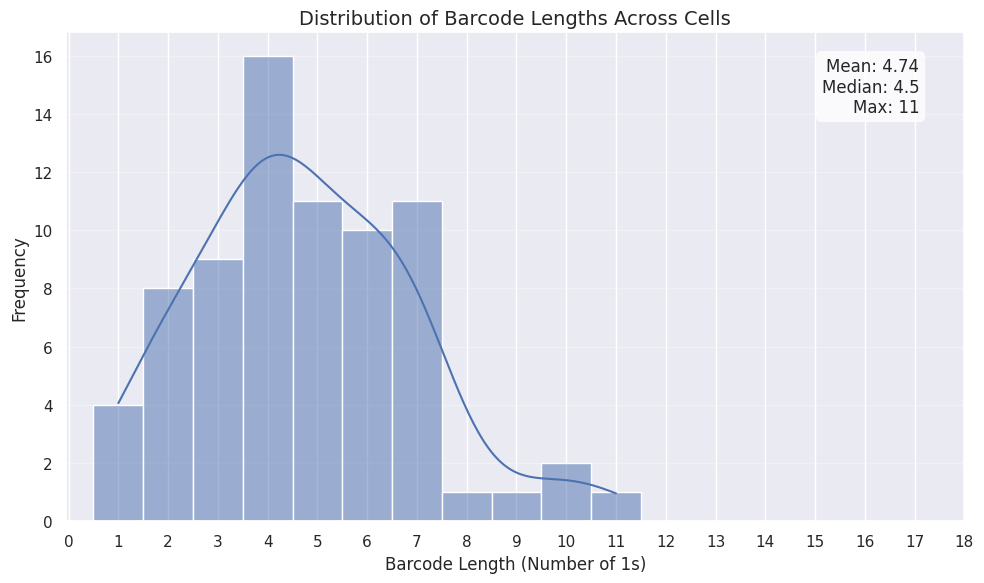

Total cells: 74
Mean barcode length: 4.74
Median barcode length: 4.5
Min barcode length: 1
Max barcode length: 11


In [6]:
# Calculate barcode length (sum of 1s) for each cell
barcode_lengths = np.sum(soma_barcodes, axis=1)

# Create a figure with appropriate size
plt.figure(figsize=(10, 6))

# Create the histogram
sns.histplot(barcode_lengths, kde=True, bins=range(19), discrete=True)

# Add labels and title
plt.xlabel('Barcode Length (Number of 1s)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Barcode Lengths Across Cells', fontsize=14)

# Set x-axis ticks to include all possible barcode lengths (0 to 18)
plt.xticks(range(19))

# Add a grid for better readability
plt.grid(axis='y', alpha=0.3)

# Calculate some statistics to add as text
mean_length = np.mean(barcode_lengths)
median_length = np.median(barcode_lengths)
max_length = np.max(barcode_lengths)

# Add statistics as text
stats_text = f"Mean: {mean_length:.2f}\nMedian: {median_length:.1f}\nMax: {max_length:.0f}"
plt.text(0.95, 0.95, stats_text, transform=plt.gca().transAxes, 
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# Show the plot
plt.tight_layout()
plt.show()

# Also print basic statistics
print(f"Total cells: {len(barcode_lengths)}")
print(f"Mean barcode length: {mean_length:.2f}")
print(f"Median barcode length: {median_length}")
print(f"Min barcode length: {np.min(barcode_lengths)}")
print(f"Max barcode length: {max_length}")

<Figure size 4200x2400 with 0 Axes>

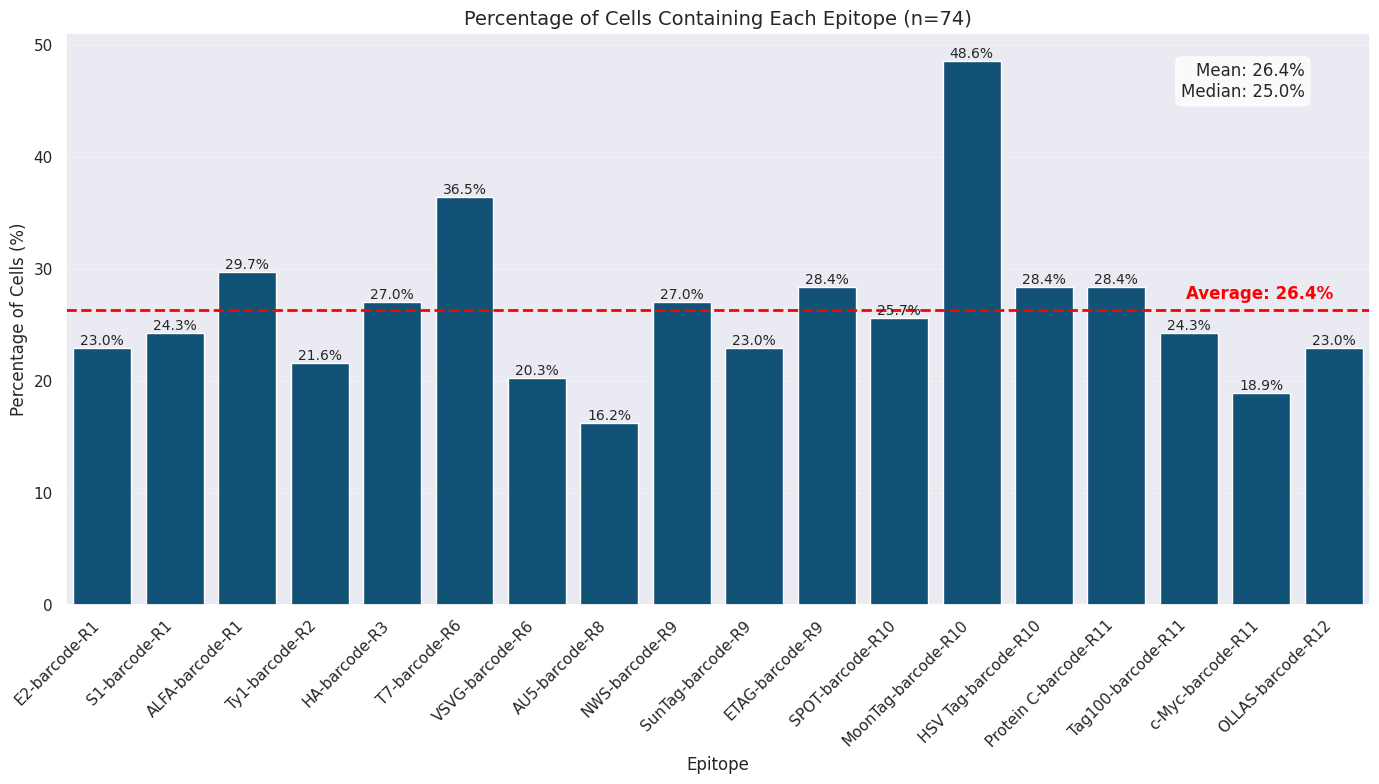


Average epitope presence: 26.35% of cells
Median epitope presence: 25.00% of cells

Epitope distribution (% of cells):
E2-barcode-R1: 23.0% (-3.4% from average)
S1-barcode-R1: 24.3% (-2.0% from average)
ALFA-barcode-R1: 29.7% (+3.4% from average)
Ty1-barcode-R2: 21.6% (-4.7% from average)
HA-barcode-R3: 27.0% (+0.7% from average)
T7-barcode-R6: 36.5% (+10.1% from average)
VSVG-barcode-R6: 20.3% (-6.1% from average)
AU5-barcode-R8: 16.2% (-10.1% from average)
NWS-barcode-R9: 27.0% (+0.7% from average)
SunTag-barcode-R9: 23.0% (-3.4% from average)
ETAG-barcode-R9: 28.4% (+2.0% from average)
SPOT-barcode-R10: 25.7% (-0.7% from average)
MoonTag-barcode-R10: 48.6% (+22.3% from average)
HSV Tag-barcode-R10: 28.4% (+2.0% from average)
Protein C-barcode-R11: 28.4% (+2.0% from average)
Tag100-barcode-R11: 24.3% (-2.0% from average)
c-Myc-barcode-R11: 18.9% (-7.4% from average)
OLLAS-barcode-R12: 23.0% (-3.4% from average)


In [7]:
plt.figure(figsize=(14, 8), dpi=300)

epitope_counts = np.sum(soma_barcodes, axis=0)  # Sum each column
total_cells = len(soma_barcodes)
epitope_percentages = (epitope_counts / total_cells) * 100

# Calculate the average percentage
mean_percentage = np.mean(epitope_percentages)
median_percentage = np.median(epitope_percentages)

# Create a DataFrame for easier plotting with the target names
epitope_df = pd.DataFrame({
    'Epitope': target_channels,
    'Percentage': epitope_percentages
})

# Sort from highest to lowest percentage for better visualization
# epitope_df = epitope_df.sort_values('Percentage', ascending=False)

# Create the plot
plt.figure(figsize=(14, 8))
bars = sns.barplot(x='Epitope', y='Percentage', data=epitope_df, color=e11_color)

# Add percentage labels on top of each bar
for i, p in enumerate(bars.patches):
    bars.annotate(f'{p.get_height():.1f}%', 
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom', fontsize=10)

# Add a horizontal line for the average
plt.axhline(y=mean_percentage, color='red', linestyle='--', linewidth=2)
plt.text(len(epitope_df)-1, mean_percentage+1, f'Average: {mean_percentage:.1f}%', 
         color='red', fontweight='bold', ha='right')

# Add labels and title
plt.xlabel('Epitope', fontsize=12)
plt.ylabel('Percentage of Cells (%)', fontsize=12)
plt.title('Percentage of Cells Containing Each Epitope (n=74)', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add grid lines for easier reading
plt.grid(axis='y', alpha=0.3)

# Add statistics as text
stats_text = f"Mean: {mean_percentage:.1f}%\nMedian: {median_percentage:.1f}%"
plt.text(0.95, 0.95, stats_text, transform=plt.gca().transAxes,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# Adjust layout and show plot
plt.tight_layout()
plt.show()

# Print the average clearly
print(f"\nAverage epitope presence: {mean_percentage:.2f}% of cells")
print(f"Median epitope presence: {median_percentage:.2f}% of cells")

# Also print the percentage for each epitope
print("\nEpitope distribution (% of cells):")
for epitope, percentage in zip(epitope_df['Epitope'], epitope_df['Percentage']):
    diff_from_avg = percentage - mean_percentage
    print(f"{epitope}: {percentage:.1f}% ({diff_from_avg:+.1f}% from average)")




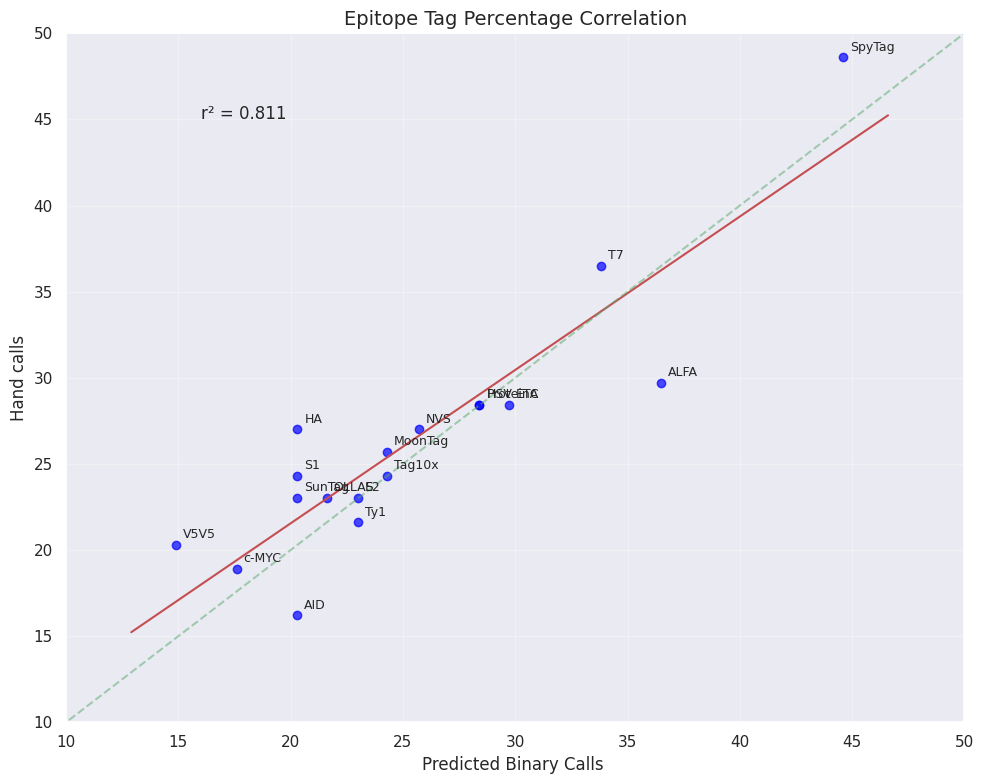

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Epitope names (shortened for better readability)
epitopes = [
    "E2", "S1", "ALFA", "Ty1", "HA", "T7", "V5V5", "AID", 
    "NVS", "SunTag", "ETC", "SpyTag", "MoonTag", "HSV", 
    "ProteinA", "Tag10x", "c-MYC", "OLLAS"
]

# Data from Image 1 (Barcode distribution of Somas)
dataset1 = [
    23.0, 20.3, 36.5, 23.0, 20.3, 33.8, 14.9, 20.3, 25.7, 20.3, 29.7, 44.6, 
    24.3, 28.4, 28.4, 24.3, 17.6, 21.6
] # predicted

# Data from Image 2 (Percentage of Cells Containing Each Epitope)
dataset2 = [
    23.0, 24.3, 29.7, 21.6, 27.0, 36.5, 20.3, 16.2, 27.0, 23.0, 28.4, 48.6, 
    25.7, 28.4, 28.4, 24.3, 18.9, 23.0
] # hand called 

# Calculate correlation and linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(dataset1, dataset2)
r_squared = r_value**2

# Create the plot
plt.figure(figsize=(10, 8))
plt.scatter(dataset1, dataset2, c='blue', alpha=0.7)

# Add labels for each point
for i, epitope in enumerate(epitopes):
    plt.annotate(epitope, (dataset1[i], dataset2[i]), 
                 xytext=(5, 5), textcoords='offset points',
                 fontsize=9)

# Add regression line
x_range = np.linspace(min(dataset1)-2, max(dataset1)+2, 100)
plt.plot(x_range, slope * x_range + intercept, 'r-')

# Add text with correlation information
plt.text(16, 45, f'r² = {r_squared:.3f}', fontsize=12)

# Set labels and title
plt.xlabel('Predicted Binary Calls ', fontsize=12)
plt.ylabel('Hand calls', fontsize=12)
plt.title('Epitope Tag Percentage Correlation', fontsize=14)

# Set equal aspect ratio and axis limits
plt.axis([10, 50, 10, 50])

# Add identity line (y=x)
plt.plot([0, 50], [0, 50], 'g--', alpha=0.5)

# Add grid
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Collisions

Total cells/somas: 74
Unique barcodes: 73
Barcode collision distribution: {0: 72, 1: 2}
Percentage of cells with unique barcodes: 97.30%


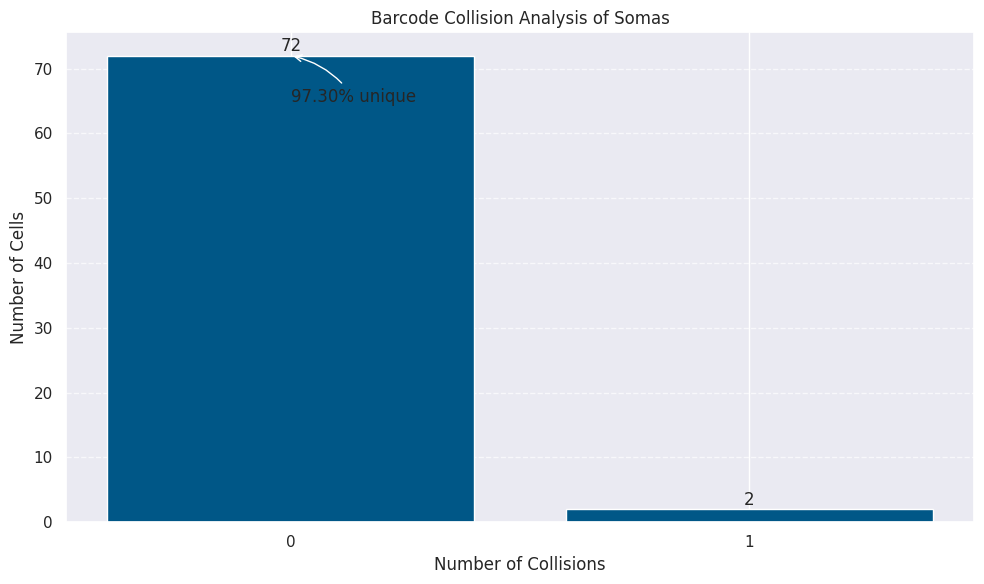

In [9]:
# Collision Analysis and Visualization
def analyze_barcode_collisions(segments_array):
    """
    Analyze barcode collisions in the segments array.
    
    Parameters:
    - segments_array: numpy array where each row represents a cell/soma and each column is a barcode bit
    
    Returns:
    - Dictionary containing collision analysis results
    """
    # Create a tuple for each barcode to make it hashable for counting
    barcodes = [tuple(row) for row in segments_array]
    
    # Count occurrences of each barcode
    from collections import Counter
    barcode_counts = Counter(barcodes)
    
    # Calculate collision statistics
    collision_counts = Counter(barcode_counts.values())
    
    # For each count value, the number of cells having that many collisions
    # is count_value * number_of_barcodes_with_that_count
    collision_distribution = {}
    total_cells = len(segments_array)
    total_accounted = 0
    
    for count_value, num_barcodes in sorted(collision_counts.items()):
        num_cells = count_value * num_barcodes
        collision_distribution[count_value-1] = num_cells  # count_value-1 is the number of collisions
        total_accounted += num_cells
    
    # Verify all cells are accounted for
    assert total_accounted == total_cells, f"Error: {total_accounted} cells accounted for, but expected {total_cells}"
    
    return {
        'collision_distribution': collision_distribution,
        'total_cells': total_cells,
        'unique_barcodes': len(barcode_counts),
        'barcode_counts': barcode_counts
    }

# Assuming 'segments' is your array containing all barcodes for the 147 somas
# If you need to create it from the processed dataframe, use:
# segments = processed_df[target_channels].values

# Analyze collisions
collision_results = analyze_barcode_collisions(soma_barcodes)

# Display basic statistics
print(f"Total cells/somas: {collision_results['total_cells']}")
print(f"Unique barcodes: {collision_results['unique_barcodes']}")
print(f"Barcode collision distribution: {collision_results['collision_distribution']}")

# Calculate what percentage of cells have a unique barcode
unique_cells = collision_results['collision_distribution'].get(0, 0)
percent_unique = (unique_cells / collision_results['total_cells']) * 100
print(f"Percentage of cells with unique barcodes: {percent_unique:.2f}%")

# Create a visualization of the collision distribution
plt.figure(figsize=(10, 6))
collision_data = collision_results['collision_distribution']
collisions = sorted(collision_data.keys())
cell_counts = [collision_data[c] for c in collisions]

# Bar plot
bars = plt.bar(collisions, cell_counts, color=e11_color)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height}', ha='center', va='bottom')

plt.title('Barcode Collision Analysis of Somas')
plt.xlabel('Number of Collisions')
plt.ylabel('Number of Cells')
plt.xticks(collisions)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add percentage annotation for unique barcodes
plt.annotate(f"{percent_unique:.2f}% unique", 
             xy=(0, cell_counts[collisions.index(0)] if 0 in collisions else 0), 
             xytext=(0, max(cell_counts)*0.9),
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

plt.tight_layout()
plt.show()

In [10]:
# plotting hamming weights distribution of hand called somas




## Hamming Distance analysis

Note: there are only skeletons for 

In [11]:
# compute distance matrix
dist = distance.pdist(soma_barcodes, metric="hamming")
matrix = distance.squareform(dist)

# Set values close to zero, directly to zero (for cosine precision)
matrix[matrix < 1e-10] = 0

matrix

array([[0.        , 0.55555556, 0.55555556, ..., 0.44444444, 0.44444444,
        0.38888889],
       [0.55555556, 0.        , 0.55555556, ..., 0.44444444, 0.33333333,
        0.38888889],
       [0.55555556, 0.55555556, 0.        , ..., 0.44444444, 0.44444444,
        0.5       ],
       ...,
       [0.44444444, 0.44444444, 0.44444444, ..., 0.        , 0.33333333,
        0.61111111],
       [0.44444444, 0.33333333, 0.44444444, ..., 0.33333333, 0.        ,
        0.38888889],
       [0.38888889, 0.38888889, 0.5       , ..., 0.61111111, 0.38888889,
        0.        ]], shape=(74, 74))

In [12]:
bit_differences = matrix * soma_barcodes.shape[1]

max_bit_difference = int(np.max(bit_differences))
bins = np.arange(0, max_bit_difference + 1)

rows, columns = bit_differences.shape
flat = bit_differences.reshape(rows * columns)

print(flat)

[ 0. 10. 10. ... 11.  7.  0.]


[ 0  0  0 ... 15 16 16]


NameError: name 'num_columns' is not defined

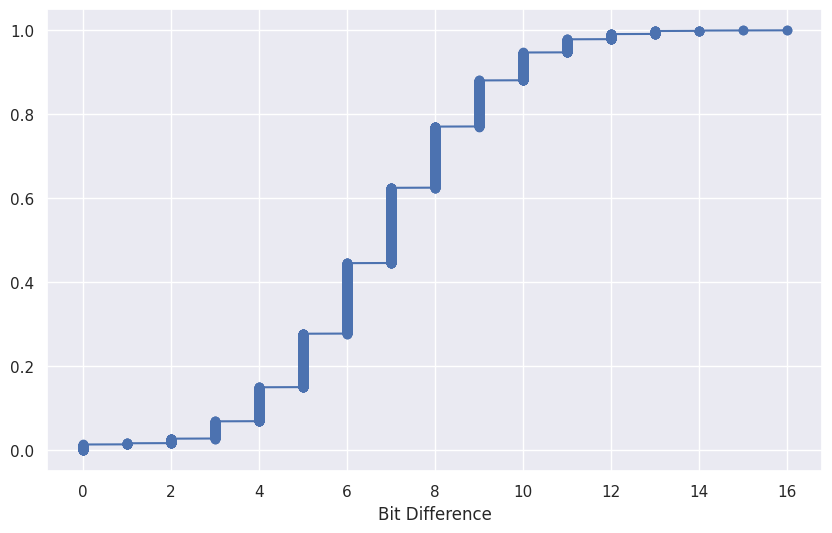

In [13]:
# Plotting the cumulative histogram
plt.figure(figsize=(10, 6))

# sort the data in ascending order
x = np.sort(flat).astype(int)

print(x)

num_cells = x.shape[0]

# get the cdf values of y
y = np.arange(num_cells) / float(num_cells)

plt.plot(x, y, marker="o")
plt.xlabel("Bit Difference")
plt.xticks(list(range(num_columns+1)))
plt.ylabel("Cumulative Probability")
plt.title(
    "Cumulative hist of pairwise hamming distances of"
    f" {total_cells} cells"
)
plt.grid(True)

array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
       10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5])

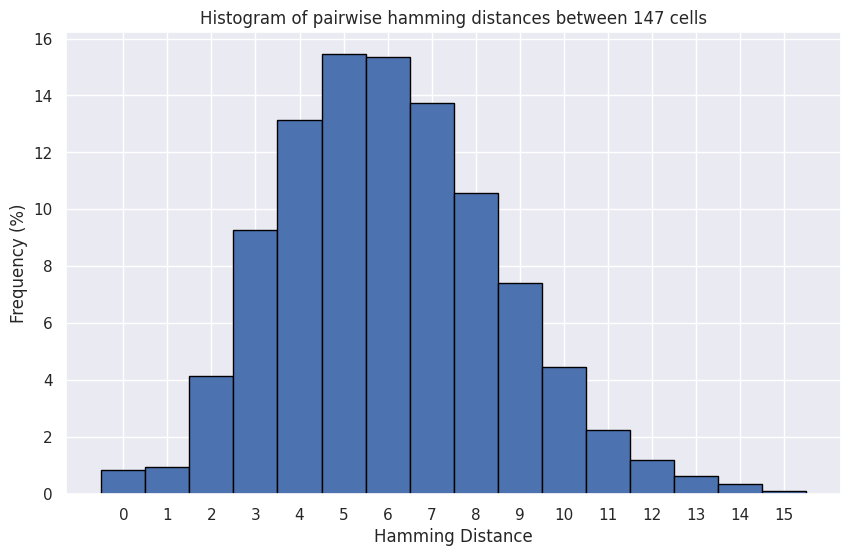

In [35]:
# Plot histogram of hamming distances
plt.figure(figsize=(10, 6))
plt.hist(flat, bins=bins, edgecolor='black', weights=np.ones_like(flat)/len(flat)*100, align='mid')
plt.xlabel("Hamming Distance")
plt.ylabel("Frequency (%)")
plt.title(f"Histogram of pairwise hamming distances between {total_cells} cells")
plt.xticks(bins[:-1] + 0.5, bins[:-1])


np.arange(-0.5, soma_barcodes.shape[1] + 1.5)

Original data: (147, 18), Filtered data: (147, 18)


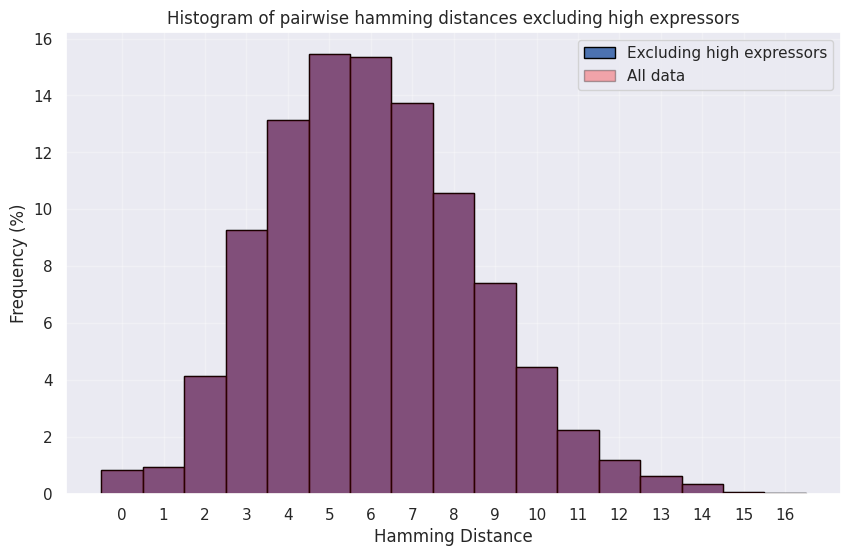

Mean hamming distance for all data: 6.06
Mean hamming distance excluding high expressors: 6.06


In [41]:
expressions_per_object = np.nansum(soma_barcodes, axis=1)



# Create a mask to exclude high expressors (neurons expressing > 17 channels)
mask = expressions_per_object <= 17  # Excludes the high expressors

# Get the filtered thresholded data
filtered_thresholded = soma_barcodes[mask]
print(f"Original data: {soma_barcodes.shape}, Filtered data: {filtered_thresholded.shape}")

# Compute new distance matrix on filtered data
filtered_dist = distance.pdist(filtered_thresholded, metric="hamming")
filtered_matrix = distance.squareform(filtered_dist)

# Set values close to zero, directly to zero (for precision)
filtered_matrix[filtered_matrix < 1e-10] = 0

# Convert to bit differences
filtered_bit_differences = filtered_matrix * filtered_thresholded.shape[1]

# Flatten the matrix
rows, columns = filtered_bit_differences.shape
filtered_flat = filtered_bit_differences.reshape(rows * columns)

# Plot histogram of hamming distances for filtered data
plt.figure(figsize=(10, 6))

# Get bin parameters
max_bit_difference = int(np.max(filtered_bit_differences))
bins = np.arange(0, max_bit_difference + 2)

# Create histogram with percentage frequency
plt.hist(filtered_flat, bins=bins, edgecolor='black', 
         weights=np.ones_like(filtered_flat)/len(filtered_flat)*100, align='mid')

plt.xlabel("Hamming Distance")
plt.ylabel("Frequency (%)")
plt.title(f"Histogram of pairwise hamming distances excluding high expressors")
plt.xticks(bins[:-1] + 0.5, bins[:-1])

# For comparison, add the original histogram in a different color with transparency
plt.hist(flat, bins=np.arange(0, int(np.max(bit_differences)) + 2), 
         edgecolor='black', alpha=0.3, color='red',
         weights=np.ones_like(flat)/len(flat)*100, align='mid')

plt.legend(['Excluding high expressors', 'All data'])
plt.grid(alpha=0.3)
plt.show()

# Calculate mean hamming distances
mean_all = np.mean(flat)
mean_filtered = np.mean(filtered_flat)

print(f"Mean hamming distance for all data: {mean_all:.2f}")
print(f"Mean hamming distance excluding high expressors: {mean_filtered:.2f}")


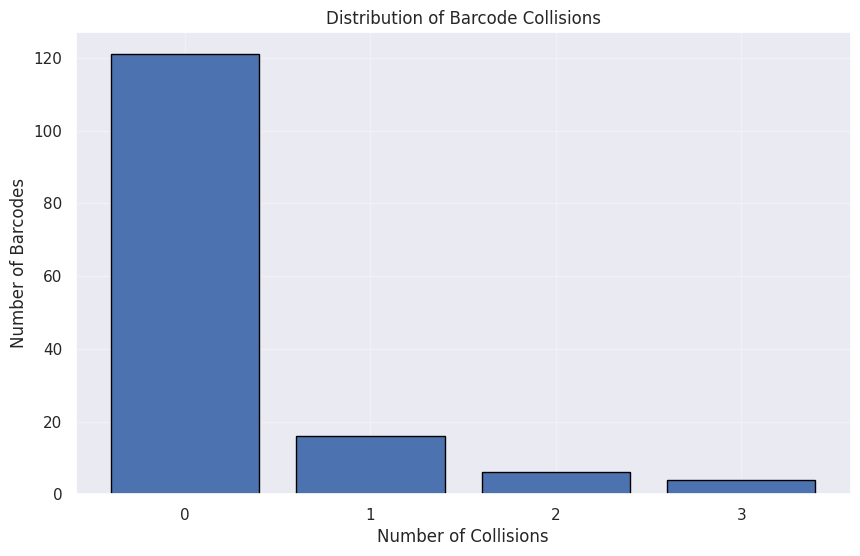

Total number of barcodes: 147

Barcode collision statistics:
Barcodes with 0 collision(s): 121 (82.3%)
Barcodes with 1 collision(s): 16 (10.9%)
Barcodes with 2 collision(s): 6 (4.1%)
Barcodes with 3 collision(s): 4 (2.7%)


In [43]:
# Count number of barcodes that have X collisions
collision_freq = {}
for i in range(len(filtered_bit_differences)):
    # Count how many collisions (hamming distance 0) this barcode has with others
    collisions = np.sum(filtered_bit_differences[i,:] == 0) - 1  # subtract 1 to exclude self-comparison
    
    # Use exact collision count as the key
    bin_key = str(collisions)
    
    if bin_key not in collision_freq:
        collision_freq[bin_key] = 0
    collision_freq[bin_key] += 1

# Create plot with ordered categories
# Find the maximum collision count
max_collision = max([int(k) for k in collision_freq.keys()]) if collision_freq else 0
categories = [str(i) for i in range(max_collision + 1)]
counts = [collision_freq.get(cat, 0) for cat in categories]

plt.figure(figsize=(10,6))
plt.bar(categories, counts, width=0.8, edgecolor='black')

plt.xlabel('Number of Collisions')
plt.ylabel('Number of Barcodes')
plt.title('Distribution of Barcode Collisions')

plt.grid(alpha=0.3)
plt.show()

# Print statistics
total_barcodes = sum(collision_freq.values())
print(f"Total number of barcodes: {total_barcodes}")
print("\nBarcode collision statistics:")
for cat in categories:
    count = collision_freq.get(cat, 0)
    print(f"Barcodes with {cat} collision(s): {count} ({count/total_barcodes*100:.1f}%)")




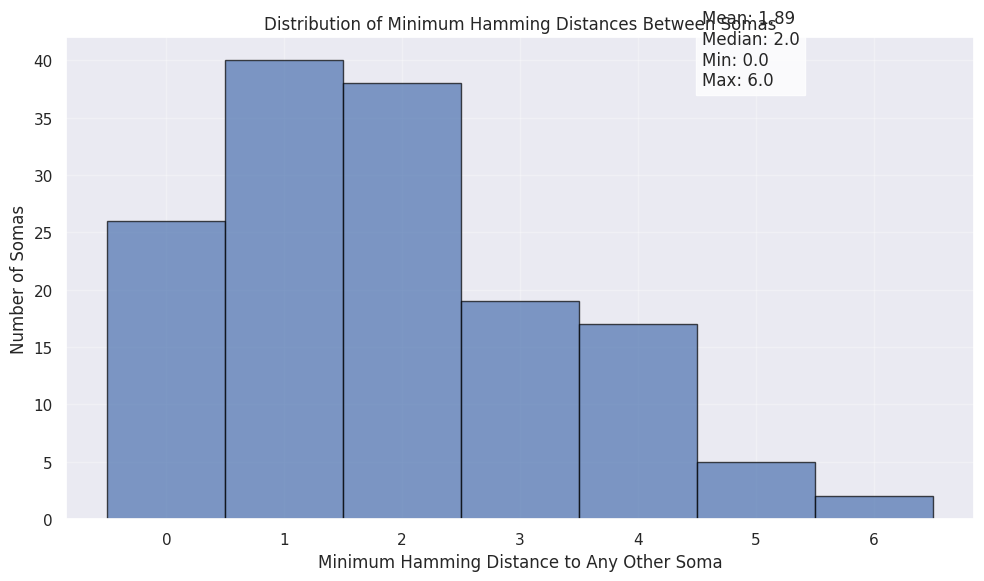

Minimum Hamming Distance Statistics:
Mean: 1.89
Median: 2.0
Min: 0.0
Max: 6.0

Distribution of minimum hamming distances:
Somas with min distance 0.0: 26 (17.7%)
Somas with min distance 1.0: 40 (27.2%)
Somas with min distance 2.0: 38 (25.9%)
Somas with min distance 3.0: 19 (12.9%)
Somas with min distance 4.0: 17 (11.6%)
Somas with min distance 5.0: 5 (3.4%)
Somas with min distance 6.0: 2 (1.4%)


In [45]:
# Calculate the minimum hamming distance for each soma (excluding self-comparison)
min_hamming_distances = []

for i in range(len(filtered_bit_differences)):
    # Get all hamming distances for this soma
    distances = filtered_bit_differences[i,:]
    
    # Create a mask to exclude self-comparison (which would have distance 0)
    mask = np.ones(len(distances), dtype=bool)
    mask[i] = False
    
    # Find the minimum distance excluding self
    min_distance = np.min(distances[mask])
    min_hamming_distances.append(min_distance)

# Convert to numpy array for easier analysis
min_hamming_distances = np.array(min_hamming_distances)

# Calculate statistics
min_distance_mean = np.mean(min_hamming_distances)
min_distance_median = np.median(min_hamming_distances)
min_distance_min = np.min(min_hamming_distances)
min_distance_max = np.max(min_hamming_distances)

# Create histogram
plt.figure(figsize=(10, 6))
bins = np.arange(min_distance_min - 0.5, min_distance_max + 1.5, 1)
counts, edges, _ = plt.hist(min_hamming_distances, bins=bins, edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Minimum Hamming Distance to Any Other Soma')
plt.ylabel('Number of Somas')
plt.title('Distribution of Minimum Hamming Distances Between Somas')
plt.xticks(range(int(min_distance_min), int(min_distance_max) + 1))
plt.grid(alpha=0.3)

# Add statistics as text
plt.text(0.7, 0.9, f'Mean: {min_distance_mean:.2f}\nMedian: {min_distance_median:.1f}\nMin: {min_distance_min}\nMax: {min_distance_max}', 
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Minimum Hamming Distance Statistics:")
print(f"Mean: {min_distance_mean:.2f}")
print(f"Median: {min_distance_median:.1f}")
print(f"Min: {min_distance_min}")
print(f"Max: {min_distance_max}")

# Count how many somas have a minimum hamming distance of 1, 2, 3, etc.
unique_distances, counts = np.unique(min_hamming_distances, return_counts=True)
print("\nDistribution of minimum hamming distances:")
for dist, count in zip(unique_distances, counts):
    percentage = (count / len(min_hamming_distances)) * 100
    print(f"Somas with min distance {dist}: {count} ({percentage:.1f}%)")



Found 18 barcode channels.

Hamming Weight Statistics for All Data:
mean: 3.9523809523809526
median: 4.0
std: 2.511162295244845
min: 0
max: 15
count: 147

Hamming Weight Statistics for Cells Only:
mean: 4.926829268292683
median: 5.0
std: 2.240426788610141
min: 1
max: 10
count: 41

Comparing to Theoretical Distribution:
Chi-square test: chi2=4.41, p-value=0.4924


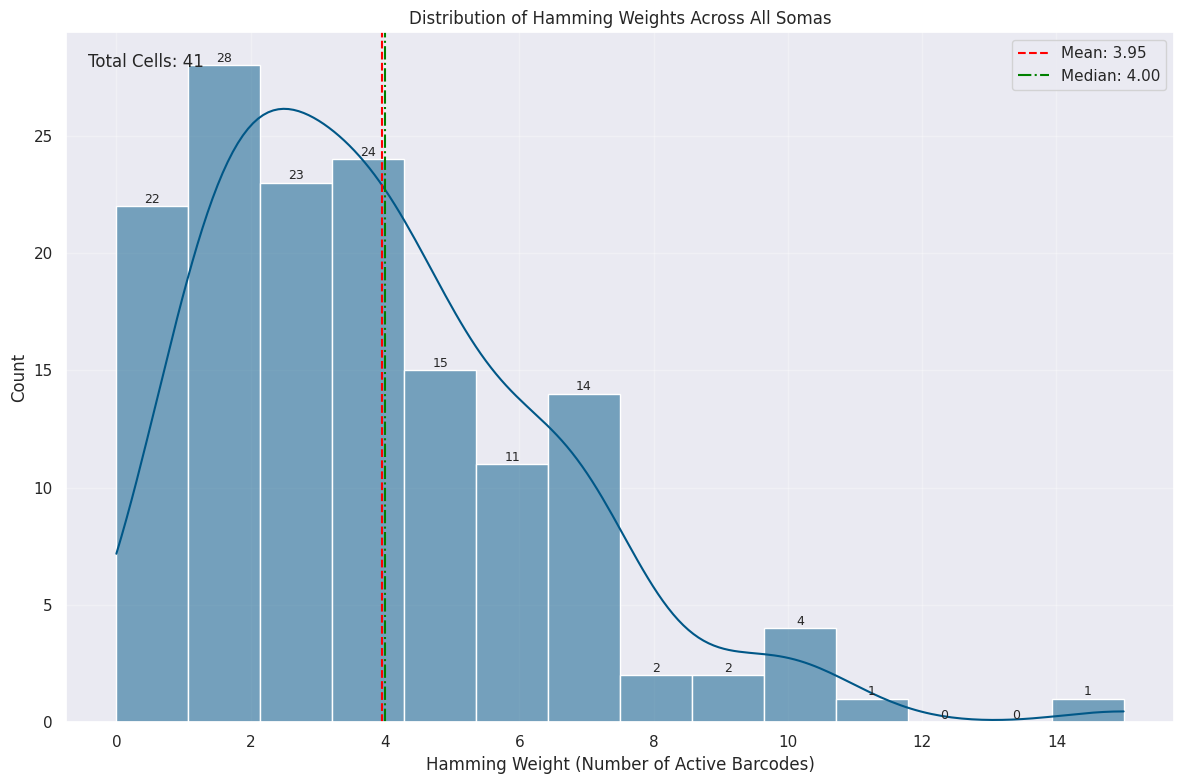

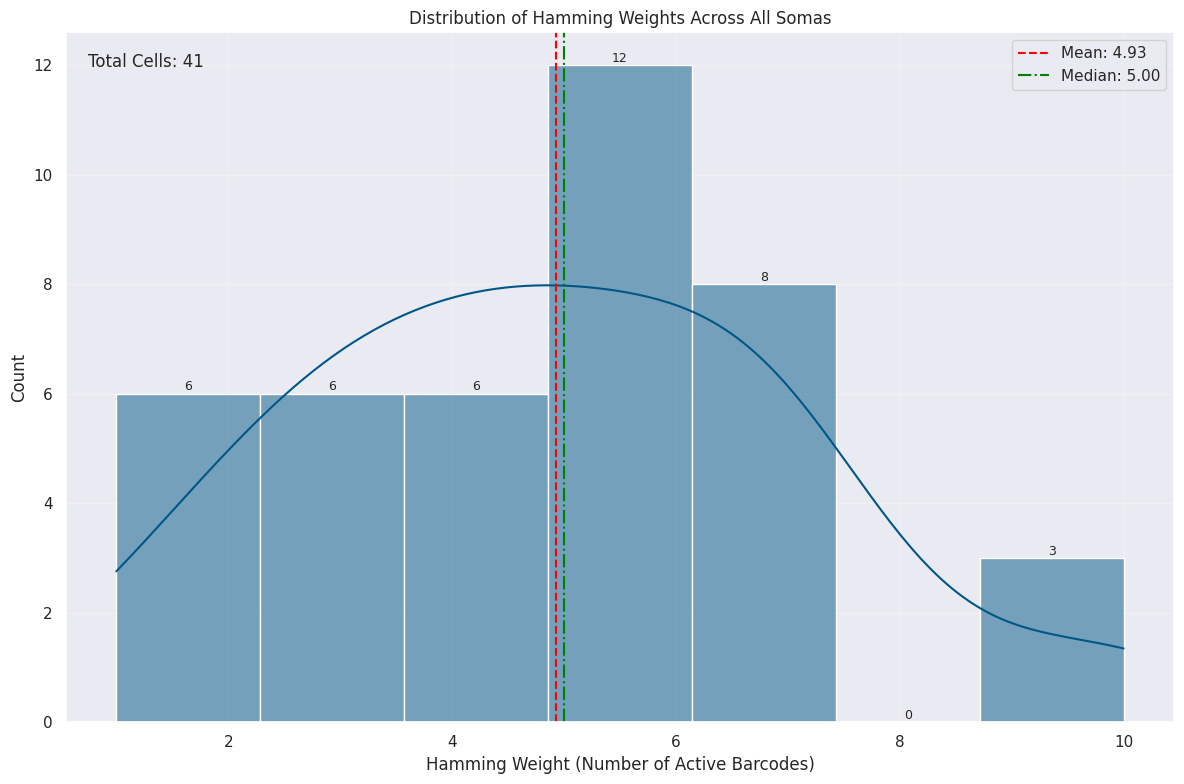

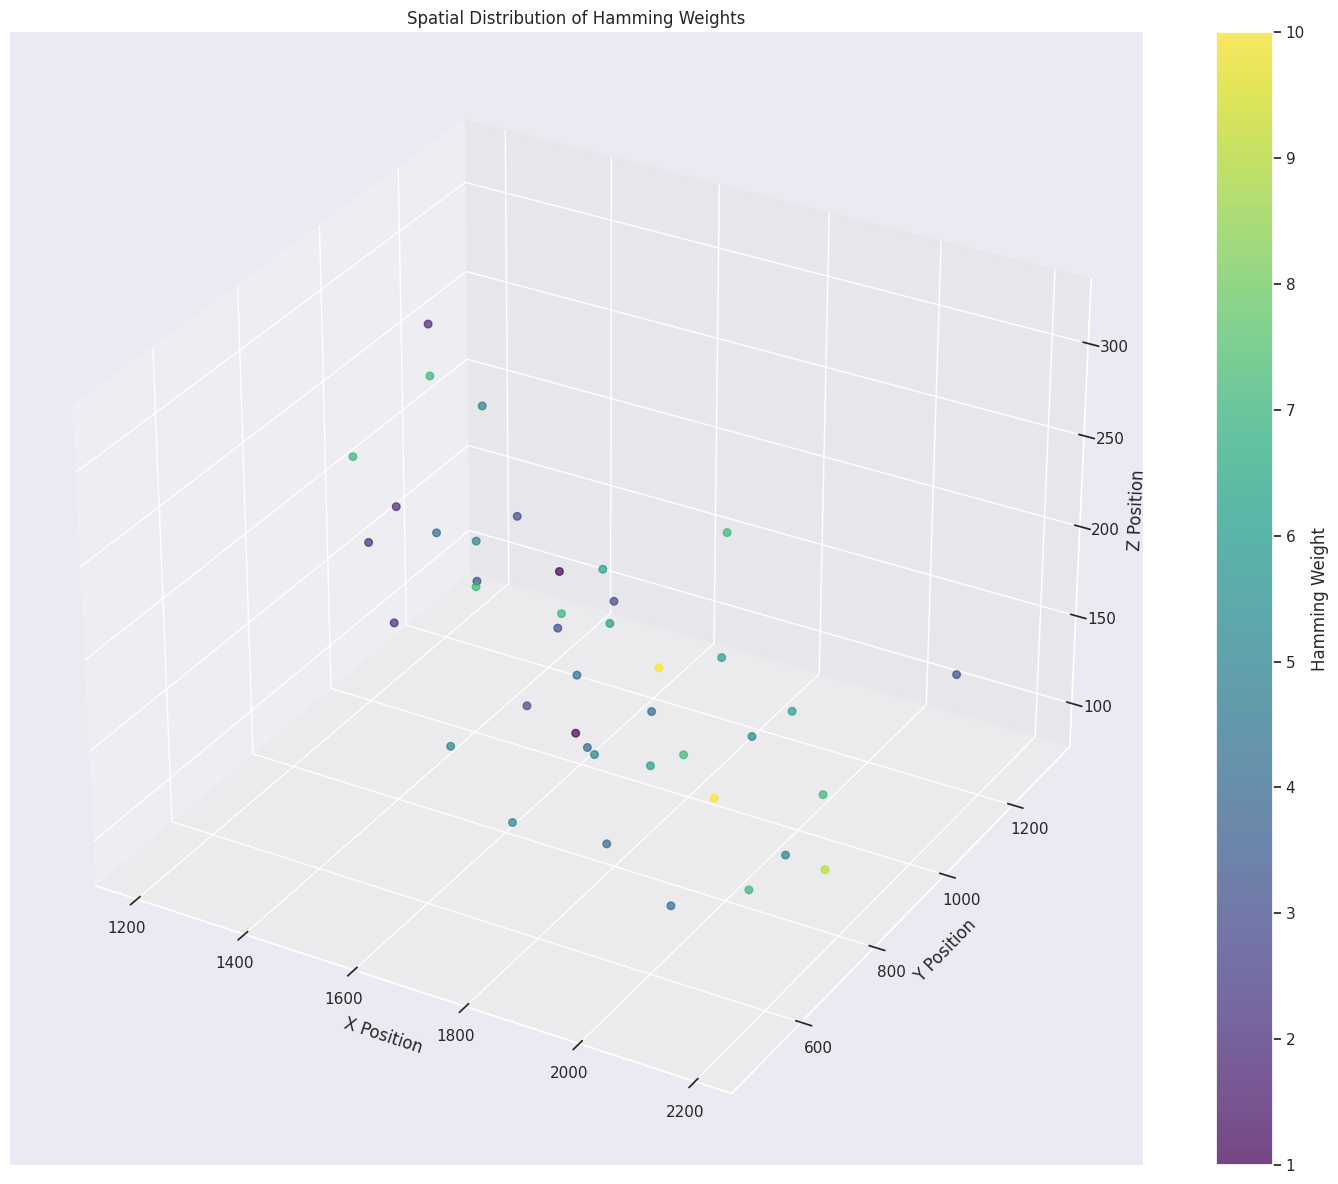

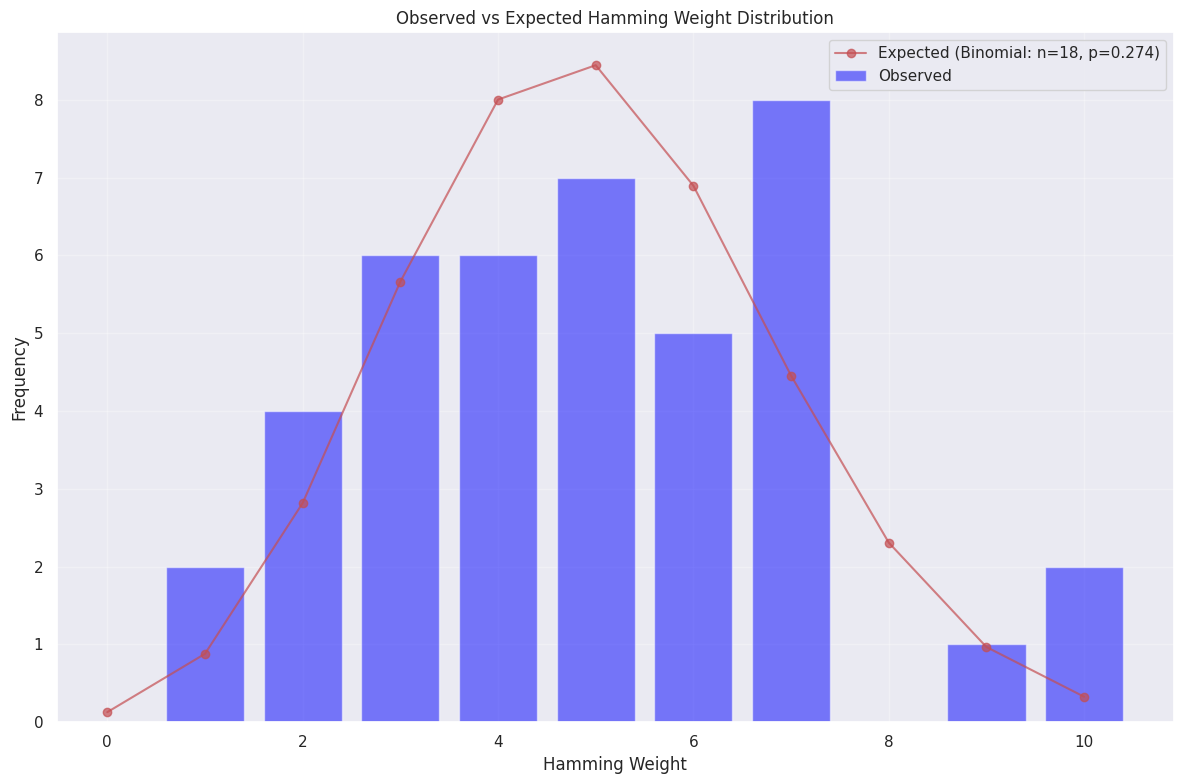

In [12]:
from hamming_weight_analysis import run_hamming_weight_analysis

# Run the complete analysis
weighted_df, stats = run_hamming_weight_analysis(filtered_df)